In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import platform
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
print(f'Pytorch version: {torch.__version__}')
print(f'cuda version: {torch.version.cuda}')
print(f'Python version: {platform.python_version()}')

Pytorch version: 2.4.0
cuda version: 12.4
Python version: 3.10.14


In [3]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Load data and normalize

### Normalization


In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#transform = transforms.Compose([transforms.ToTensor()])

Normalization adjusts the values of the image tensors using the following formula:

 $X_{normalized}$ = $\frac{X - \mu}{\sigma}$


where:

- X is the value of each pixel in the image.
- $\mu$ is the mean of the pixel values, which in this case is 0.5.
- σ is the standard deviation, also 0.5 in this case.

shifts the values to the range [-1, 1].

### Data splitting and more

In [5]:
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
print("Training size:", len(train_dataset))
print("Test size:", len(test_dataset))

Training size: 60000
Test size: 10000


In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

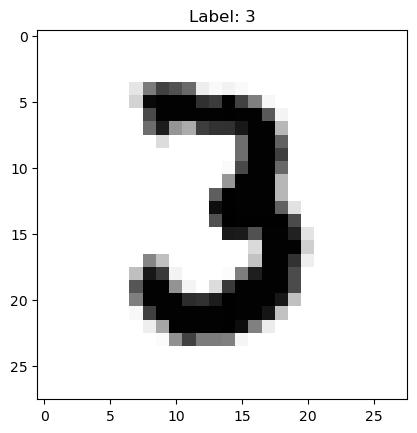

In [8]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [9]:
images[0].shape

torch.Size([1, 28, 28])

In [10]:
images[0].unique()

tensor([-1.0000, -0.9765, -0.9686, -0.9608, -0.9529, -0.9451, -0.9373, -0.9216,
        -0.9137, -0.9059, -0.8980, -0.8745, -0.8667, -0.8588, -0.8510, -0.7961,
        -0.7804, -0.7725, -0.7255, -0.7098, -0.6549, -0.6235, -0.5294, -0.5216,
        -0.5137, -0.5059, -0.4980, -0.4353, -0.3412, -0.3020, -0.1765, -0.1686,
        -0.1608, -0.1373, -0.0431, -0.0039,  0.0039,  0.0118,  0.0275,  0.0353,
         0.1373,  0.1451,  0.1686,  0.1843,  0.2392,  0.2627,  0.2941,  0.3255,
         0.3569,  0.3647,  0.4118,  0.4196,  0.4824,  0.4902,  0.4980,  0.5059,
         0.5137,  0.5373,  0.5451,  0.6000,  0.6078,  0.6157,  0.6549,  0.7333,
         0.7647,  0.7804,  0.7882,  0.7961,  0.8118,  0.8196,  0.8353,  0.8902,
         0.8980,  0.9216,  0.9765,  0.9843,  1.0000])

# $LeNet$-$5$ <span style="color:MediumSeaGreen">_Architecture_</span>


<img title="a title" alt="Alt text" src="images/architecture_LeNet-5.png">


LeNet-5 consists of seven layers (not counting input) with three main types of layers: convolutional layers, subsampling (pooling) layers, and fully connected layers. The model takes a 32x32 grayscale input image and produces an output with 10 classes, corresponding to the digits 0 through 9. Here’s the sequential breakdown of each layer:



### <span style="color:DodgerBlue">1. Input layer</span>
The input is a 32x32 pixel image, but in the MNIST data the images are 28x28. We need to resize the images using the normalization shown before and store it as a tensor.

### <span style="color:DodgerBlue">2. C1: First Convolutional Layer</span>

This layer performs convolution using 6 filters of size 5x5 across the input image, producing six 28x28 feature maps. Each filter extracts different local features like edges and corners.

- **Feature Maps:** 6

- **Connections:** Each unit is fully connected to C5
- **Stride:** 1 
- **Padding:** 2
- **Output Size:** 28 x 28 x 6 (since the input is 32x32 and applying a 5x5 filter reduces each dimension by 4, yielding 28x28)
- **Activation:** Sigmoid (in this work tanh is used)
- **Trainable parameters:** 156 (weight + bias = 5 x 5 x 1 x 6 + 6)
- **Connections:** 122,304 (28 x 28 x 156)


### <span style="color:DodgerBlue">3. S2: First Subsampling (Pooling) Layer</span>

This layer reduces the spatial dimensions of each of the 6 feature maps from 28x28 to 14x14 using 2x2 average pooling. Pooling helps reduce the computational load, extract dominant features, and introduces some degree of translation invariance.

- **Feature Maps:** 6

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 14 x 14 x 6
- **Activation:** None. Performs subsampling directly on the input.
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 6)
- **Conections:** 5,880 (14 x 14 x 30)


### <span style="color:DodgerBlue">4. C3: Second Convolutional Layer</span>

This layer applies 16 filters of size 5x5. Each of these filters is connected to all six feature maps from the previous layer in a complex connectivity pattern (Table I shows the set of S2 feature maps). This design choice was meant to increase the variety of patterns learned by the network.

<img title="a title" alt="Alt text" src="images/c2_table.png" width=600>

- **Feature Maps:** 16

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 10 x 10 x 16
- **Activation:** Sigmoid (in this work tanh is used)
- **Trainable parameters:** 1,516 (weight + bias = (5 x 5 x 6 x 10) + 16)
- **Conections:** 151,600 (10 x 10 x 1516)


### <span style="color:DodgerBlue">5. S4: Second Subsampling (Pooling) Layer</span>

Similar to S2, this layer reduces the spatial dimensions of the 16 feature maps from 10x10 to 5x5 using 2x2 average pooling.

- **Feature Maps:** 16

- **Filter Size:** 2 x 2
- **Padding:** 0
- **Stride:** 2
- **Output Size:** 5 x 5 x 16
- **Activation:** None
- **Trainable parameters:** 12 ((coefficient + bias) x filters = (1 + 1) x 16)
- **Conections:** 2,000 (5 x 5 x 80)


### <span style="color:DodgerBlue">6. C5: Third Convolutional Layer (Fully Connected Convolutional Layer)</span>

This layer is technically classified as a convolutional layer; however, it operates similarly to a fully connected layer since the filter size is equivalent to the input dimension (5x5). The 120 filters produce a single output each, yielding a 1x1x120 output. C5 is designated as a convolutional layer rather than a fully connected layer because if it were a fully connected layer, the size of the feature maps would exceed 1x1.

- **Feature Maps:** 120

- **Filter Size:** 5 x 5
- **Padding:** 0
- **Stride:** 1
- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Sigmoid (in this work tanh is used)
- **Trainable parameters:** 48,120 (weight + bias = (400 x 120) + 120)
- **Conections:** 48,120

### <span style="color:DodgerBlue">7. F6: Fully Connected Layer</span>

his layer has 84 neurons, each fully connected to the 120-element input vector. This part of the network is similar to a traditional multi-layer perceptron, serving to combine the extracted features from previous layers to make predictions.

- **Units:** 84

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:** Uses a scaled hyperbolic tangent function $f(a) = A 
*tanh(Sa)$
- **Trainable parameters:** 10,164 (weight + bias = (120 x 84) + 84)
- **Conections:** 10,164


### <span style="color:DodgerBlue">8. Output Layer</span>

he final layer has 10 neurons, each corresponding to one of the digit classes (0-9). This layer produces the network's output, a probability distribution over the 10 classes, using the softmax function.

 **Units:** 10

- **Output Size:** 1 x 1 x 120 (since the input is 5x5, applying a 5x5 filter results in a 1x1 output)
- **Activation:**  Euclidean Radial Basis Function units (RBF) (in this work softmax is used)

Each RBF unit $y_i$ is computed as follow: 

$y_i = \sum_{j} (x_j - w_{ij})^2$  

Modern versions use Softmax


In [11]:
# LeNet-5 (original architecture)
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # FC Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully conected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        conv2_out = torch.tanh(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        
        conv3_out = torch.tanh(self.conv3(pool2_out))
        x_flatten =  conv3_out.view(conv3_out.size(0), -1)
      
        fc1_out = torch.tanh(self.fc1(x_flatten))    
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return output


# Architecture 2: LeNet-5 with one convolutional layer removed
class LeNet5_OneConv(nn.Module):
    def __init__(self):
        super(LeNet5_OneConv, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2) # Output: 6x28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # Output: 6x14x14

        # FC Convolutional Layer
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=120, kernel_size=14, stride=1, padding=0) # Output: 120x1x1

        # Fully conected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84) # Output: 84
        self.fc2 = nn.Linear(in_features=84, out_features=10) # Output: 10

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)

        conv2_out = torch.tanh(self.conv2(pool1_out))
        x_flatten = conv2_out.view(conv2_out.size(0), -1)

        fc1_out = torch.tanh(self.fc1(x_flatten))    
        output = torch.softmax(self.fc2(fc1_out), dim=1)
        
        return output



# Architecture 3: LeNet-5 with an additional convolutional layer
class LeNet5_ExtraConv(nn.Module):
    def __init__(self):
        super(LeNet5_ExtraConv, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2) # Output: 6x28x28
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2) # Output: 6x14x14
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # Output: 16x10x10
        # Extra convolutional layer 
        self.conv_extra = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0) # Output: 32x8x8
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2) # Output: 32x4x4

        # FC Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=120, kernel_size=4, stride=1, padding=0) # 120x1x1

        # Fully conected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84) # Output: 84
        self.fc2 = nn.Linear(in_features=84, out_features=10) # Output: 10

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        conv2_out = torch.tanh(self.conv2(pool1_out))
        conv_extra_out = torch.tanh(self.conv_extra(conv2_out))
        pool2_out = self.pool2(conv_extra_out)
        
        conv3_out = torch.tanh(self.conv3(pool2_out))
        x_flatten =  conv3_out.view(conv3_out.size(0), -1)
      
        fc1_out = torch.tanh(self.fc1(x_flatten))    
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return output



lenet5 = LeNet5()
print(lenet5)

lenet5_oneconv = LeNet5_OneConv()
print(lenet5_oneconv)

lenet5_extraconv = LeNet5_ExtraConv()
print(lenet5_extraconv)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
LeNet5_OneConv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 120, kernel_size=(14, 14), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)
LeNet5_ExtraConv(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_extra)

In [12]:
def train_model(model, num_epochs=30):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    train_loss_list = []
    test_loss_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0
        
        # Training 
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        # average training loss and accuracy
        train_loss_list.append(train_loss / len(train_loader))
        train_accuracy_list.append(100 * correct_train / total_train)
        
        # Testing 
        model.eval()
        test_loss = 0
        correct_test = 0
        total_test = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        # average test loss and accuracy
        test_loss_list.append(test_loss / len(test_loader))
        test_accuracy_list.append(100 * correct_test / total_test)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss_list[-1]:.4f}, '
              f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
              f'Test Loss: {test_loss_list[-1]:.4f}, '
              f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')
    
    return train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list


# Setting device (GPU or CPU)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
lenet5_model = LeNet5()
lenet5_oneconv_model = LeNet5_OneConv()
lenet5_extraconv_model = LeNet5_ExtraConv()


print("LeNet-5")
train_loss_base, test_loss_base, train_acc_base, test_acc_base = train_model(lenet5_model)
print("\nLeNet-5 with one convolutional layer removed")
train_loss_oneconv, test_loss_oneconv, train_acc_oneconv, test_acc_oneconv = train_model(lenet5_oneconv_model)
print("\nLeNet-5 with extra convolutional layer")
train_loss_extraconv, test_loss_extraconv, train_acc_extraconv, test_acc_extraconv = train_model(lenet5_extraconv_model)

LeNet-5
Epoch [1/30], Train Loss: 1.5762, Train Accuracy: 90.53%, Test Loss: 1.5021, Test Accuracy: 96.55%
Epoch [2/30], Train Loss: 1.4985, Train Accuracy: 96.64%, Test Loss: 1.4931, Test Accuracy: 96.91%
Epoch [3/30], Train Loss: 1.4886, Train Accuracy: 97.45%, Test Loss: 1.4832, Test Accuracy: 97.90%
Epoch [4/30], Train Loss: 1.4833, Train Accuracy: 97.95%, Test Loss: 1.4827, Test Accuracy: 98.00%
Epoch [5/30], Train Loss: 1.4806, Train Accuracy: 98.17%, Test Loss: 1.4799, Test Accuracy: 98.22%
Epoch [6/30], Train Loss: 1.4786, Train Accuracy: 98.36%, Test Loss: 1.4813, Test Accuracy: 98.06%
Epoch [7/30], Train Loss: 1.4764, Train Accuracy: 98.57%, Test Loss: 1.4788, Test Accuracy: 98.30%
Epoch [8/30], Train Loss: 1.4752, Train Accuracy: 98.66%, Test Loss: 1.4774, Test Accuracy: 98.47%
Epoch [9/30], Train Loss: 1.4742, Train Accuracy: 98.78%, Test Loss: 1.4762, Test Accuracy: 98.59%
Epoch [10/30], Train Loss: 1.4728, Train Accuracy: 98.92%, Test Loss: 1.4764, Test Accuracy: 98.54%
E

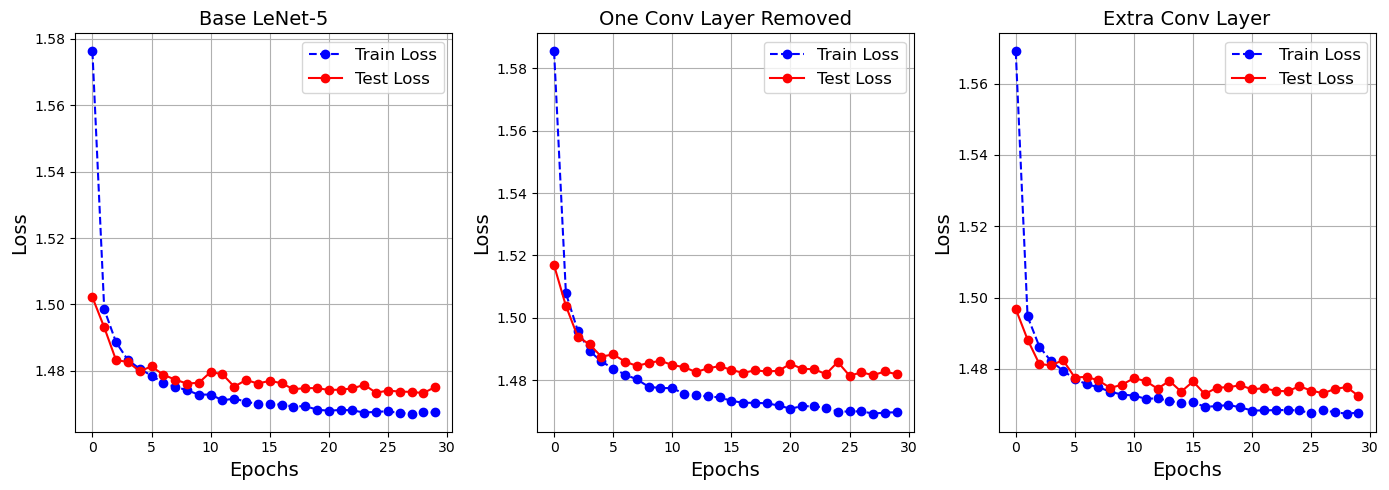

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5)) 

axs[0].plot(train_loss_base, label='Train Loss', linestyle='--', marker='o', color='blue')
axs[0].plot(test_loss_base, label='Test Loss', linestyle='-', marker='o', color='red')
axs[0].set_title('Base LeNet-5', fontsize=14)
axs[0].set_xlabel('Epochs', fontsize=14)
axs[0].set_ylabel('Loss', fontsize=14)
axs[0].legend(fontsize=12)
axs[0].grid(True)

axs[1].plot(train_loss_oneconv, label='Train Loss', linestyle='--', marker='o', color='blue')
axs[1].plot(test_loss_oneconv, label='Test Loss', linestyle='-', marker='o', color='red')
axs[1].set_title('One Conv Layer Removed', fontsize=14)
axs[1].set_xlabel('Epochs', fontsize=14)
axs[1].set_ylabel('Loss', fontsize=14)
axs[1].legend(fontsize=12)
axs[1].grid(True)

axs[2].plot(train_loss_extraconv, label='Train Loss', linestyle='--', marker='o', color='blue')
axs[2].plot(test_loss_extraconv, label='Test Loss', linestyle='-', marker='o', color='red')
axs[2].set_title('Extra Conv Layer', fontsize=14)
axs[2].set_xlabel('Epochs', fontsize=14)
axs[2].set_ylabel('Loss', fontsize=14)
axs[2].legend(fontsize=12)
axs[2].grid(True)


plt.tight_layout()
plt.show()

# Understanding LeNet-5 throught visualization

One way to try to understand how the model works is to visualize the output at each
layer, showing the features it learns in the process. Below is the output of the seven layers of
the LeNet-5 model before and after training.

### Visualization after trainning

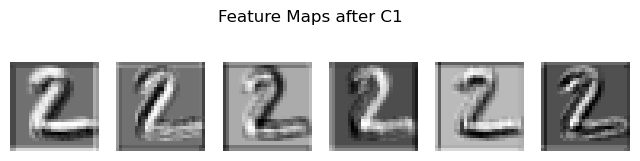

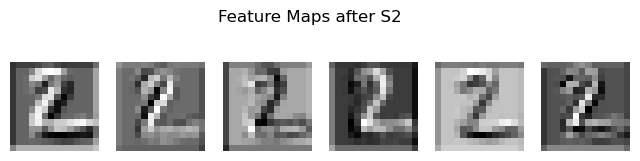

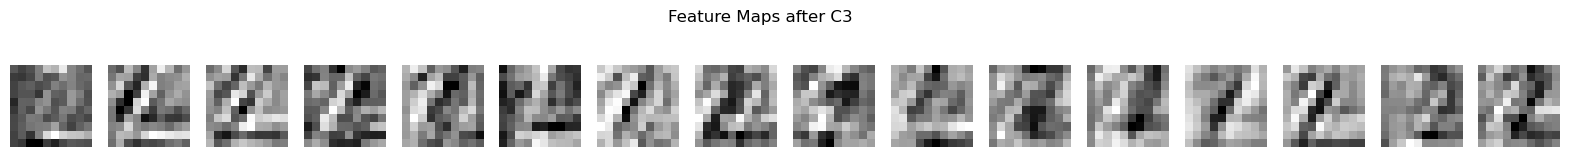

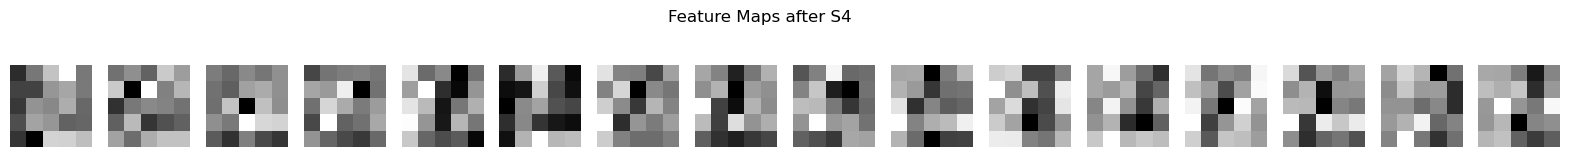

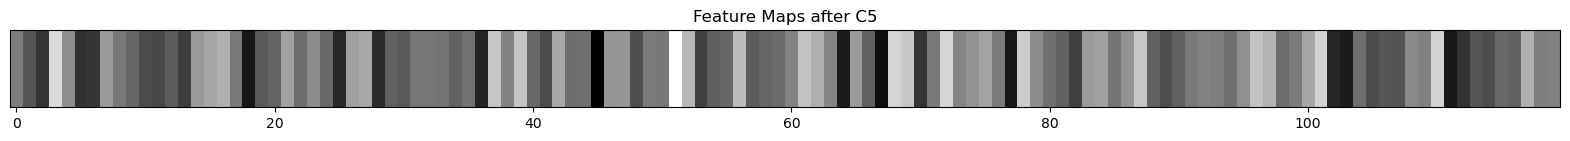

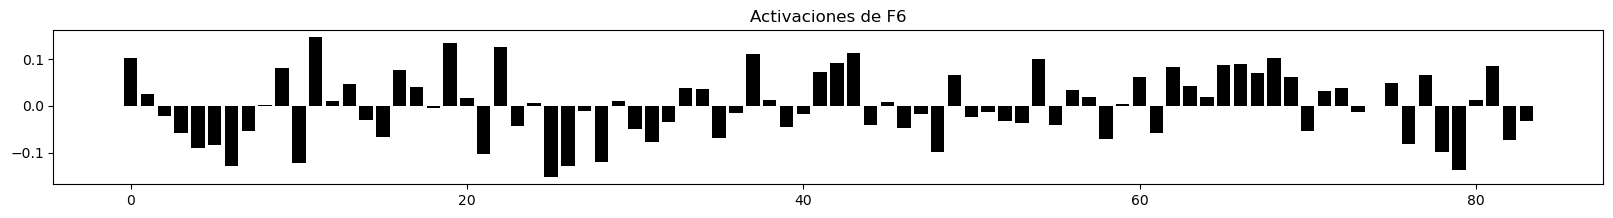

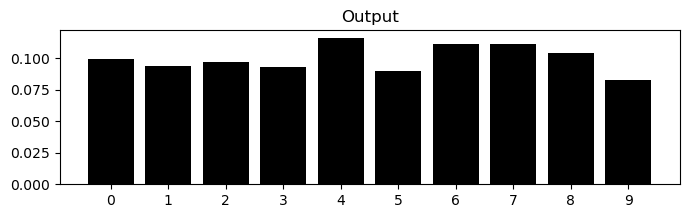

In [12]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # FC Convolutional Layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Fully conected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        conv1_out = torch.tanh(self.conv1(x))
        pool1_out = self.pool1(conv1_out)
        conv2_out = torch.tanh(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        
        conv3_out = torch.tanh(self.conv3(pool2_out))
        x_flatten =  conv3_out.view(conv3_out.size(0), -1)
      
        fc1_out = torch.tanh(self.fc1(x_flatten))    
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, output


model = LeNet5()

input_image = test_dataset[1][0].unsqueeze(0)  # torch.rand(1, 1, 28, 28)
conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, output = model(input_image)

def visualize_feature_maps(feature_maps, title, x, y):
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(x, y))
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i].detach().numpy(), cmap='binary')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_feature_maps(conv1_out, 'Feature Maps after C1', x=8, y=2)  
visualize_feature_maps(pool1_out, 'Feature Maps after S2', x=8, y=2)
visualize_feature_maps(conv2_out, 'Feature Maps after C3', x=20, y=2)
visualize_feature_maps(pool2_out, 'Feature Maps after S4', x=20, y=2)

conv3_out_flat = conv3_out.view(-1).detach().numpy()
plt.figure(figsize=(20, 1))  
plt.imshow(conv3_out_flat[np.newaxis, :], cmap='binary', aspect='auto') 
plt.title('Feature Maps after C5')
plt.yticks([])  
plt.show()

plt.figure(figsize=(20, 2))
plt.bar(range(len(fc1_out[0])), fc1_out[0].detach().numpy(), color='k')
plt.title('Activaciones de F6')
plt.show()

plt.figure(figsize=(8, 2))
plt.bar(range(len(output[0])), output[0].detach().numpy(), color='k')
plt.title('Output')
plt.xticks(np.arange(0, 10, 1))
plt.show()

### Visualization after trainning

In [37]:
model = LeNet5()

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    # Training
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, fc2_out = model(images)
        loss = criterion(fc2_out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(fc2_out.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # average training loss and accuracy
    train_loss_list.append(train_loss / len(train_loader))
    train_accuracy_list.append(100 * correct_train / total_train)
    
    # Testing 
    model.eval()
    test_loss = 0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, fc2_out = model(images)
            loss = criterion(fc2_out, labels)
            
            test_loss += loss.item()
            
            _, predicted = torch.max(fc2_out.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    
    # average test loss and accuracy
    test_loss_list.append(test_loss / len(test_loader))
    test_accuracy_list.append(100 * correct_test / total_test)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss_list[-1]:.4f}, '
            f'Train Accuracy: {train_accuracy_list[-1]:.2f}%, '
            f'Test Loss: {test_loss_list[-1]:.4f}, '
            f'Test Accuracy: {test_accuracy_list[-1]:.2f}%')

Epoch [1/30], Train Loss: 1.5747, Train Accuracy: 90.44%, Test Loss: 1.5021, Test Accuracy: 96.37%
Epoch [2/30], Train Loss: 1.4972, Train Accuracy: 96.73%, Test Loss: 1.4893, Test Accuracy: 97.33%
Epoch [3/30], Train Loss: 1.4877, Train Accuracy: 97.54%, Test Loss: 1.4865, Test Accuracy: 97.58%
Epoch [4/30], Train Loss: 1.4825, Train Accuracy: 98.03%, Test Loss: 1.4822, Test Accuracy: 98.03%
Epoch [5/30], Train Loss: 1.4799, Train Accuracy: 98.25%, Test Loss: 1.4815, Test Accuracy: 98.08%
Epoch [6/30], Train Loss: 1.4773, Train Accuracy: 98.50%, Test Loss: 1.4784, Test Accuracy: 98.37%
Epoch [7/30], Train Loss: 1.4759, Train Accuracy: 98.61%, Test Loss: 1.4798, Test Accuracy: 98.16%
Epoch [8/30], Train Loss: 1.4749, Train Accuracy: 98.72%, Test Loss: 1.4774, Test Accuracy: 98.41%
Epoch [9/30], Train Loss: 1.4740, Train Accuracy: 98.81%, Test Loss: 1.4770, Test Accuracy: 98.47%
Epoch [10/30], Train Loss: 1.4731, Train Accuracy: 98.88%, Test Loss: 1.4781, Test Accuracy: 98.38%
Epoch [11

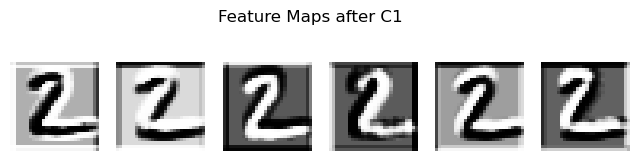

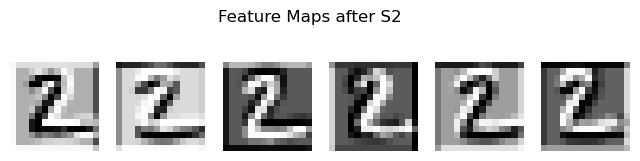

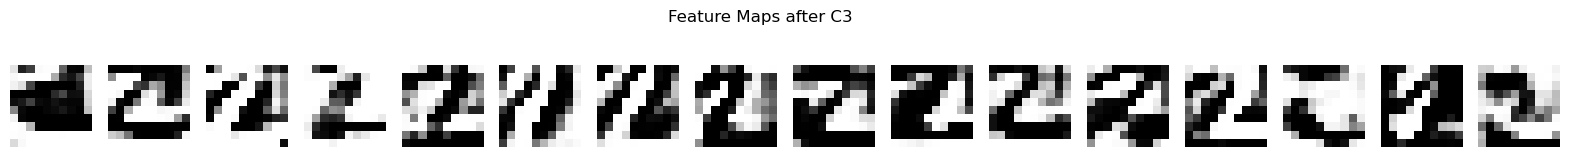

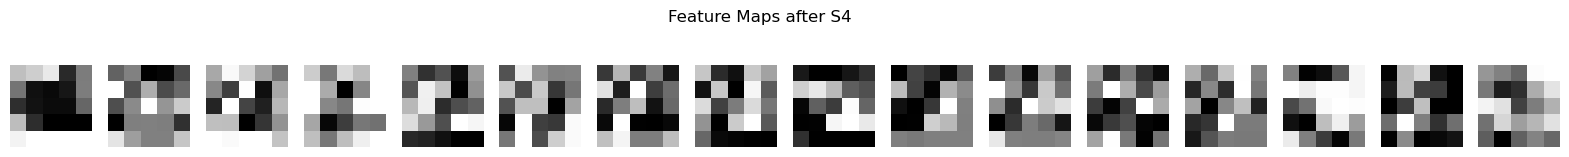

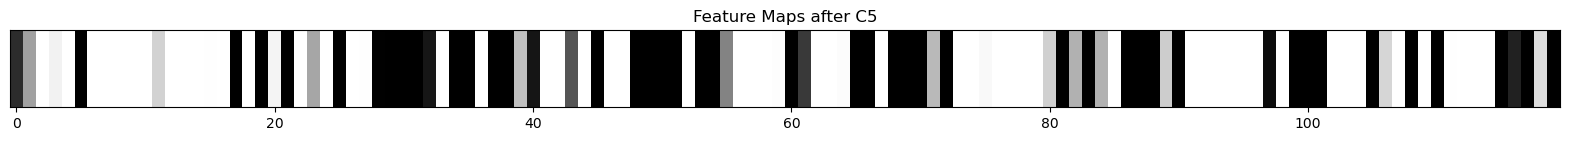

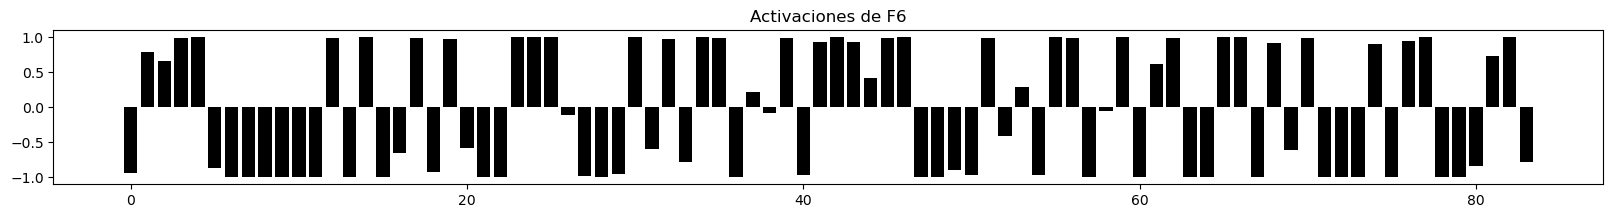

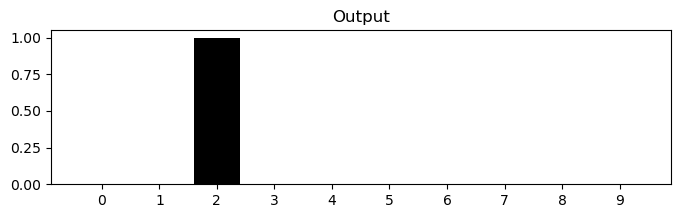

In [38]:
input_image = test_dataset[1][0].unsqueeze(0).to(device)  # torch.rand(1, 1, 28, 2)
conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, fc2_out = model(input_image)

def visualize_feature_maps(feature_maps, title, x, y):
    num_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(1, num_maps, figsize=(x, y))
    for i in range(num_maps):
        axes[i].imshow(feature_maps[0, i].detach().cpu().numpy(), cmap='binary')
        axes[i].axis('off')
    plt.suptitle(title)
    plt.show()

visualize_feature_maps(conv1_out, 'Feature Maps after C1', x=8, y=2)  
visualize_feature_maps(pool1_out, 'Feature Maps after S2', x=8, y=2)
visualize_feature_maps(conv2_out, 'Feature Maps after C3', x=20, y=2)
visualize_feature_maps(pool2_out, 'Feature Maps after S4', x=20, y=2)

conv3_out_flat = conv3_out.view(-1).detach().cpu().numpy()
plt.figure(figsize=(20, 1))  
plt.imshow(conv3_out_flat[np.newaxis, :], cmap='binary', aspect='auto') 
plt.title('Feature Maps after C5')
plt.yticks([])  
plt.show()

plt.figure(figsize=(20, 2))
plt.bar(range(len(fc1_out[0])), fc1_out[0].detach().cpu().numpy(), color='k')
plt.title('Activaciones de F6')
plt.show()

plt.figure(figsize=(8, 2))
plt.bar(range(len(fc2_out[0])), fc2_out[0].detach().cpu().numpy(), color='k')
plt.title('Output')
plt.xticks(np.arange(0, 10, 1))
plt.show()

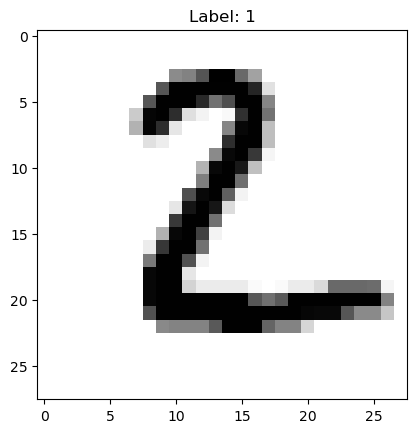

In [39]:
plt.imshow(test_dataset[1][0].numpy().squeeze(), cmap='gray_r')
plt.title(f"Label: {labels[0].item()}")
plt.show()

In [40]:
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
)

## tNSE

An alternative approach to visualize, involves extracting feature representations using t-Distributed Stochastic Neighbor Embedding (t-SNE). This method helps preserve distances in the high-dimensional feature space, as illustrated in the following figure. Such visualizations provide insights into the quality of learned features across classes, indicating that closely clustered classes are more accurately classified than those with extensive overlap, which complicates the modeling of classification boundaries.

In [41]:
from sklearn.manifold import TSNE

def extract_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            conv1_out, pool1_out, conv2_out, pool2_out, conv3_out, fc1_out, output = model(x)
            features.append(output.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

model = model
features, labels = extract_features(model, test_loader)

tsne = TSNE(n_components=2)
tsne_features_output = tsne.fit_transform(features)

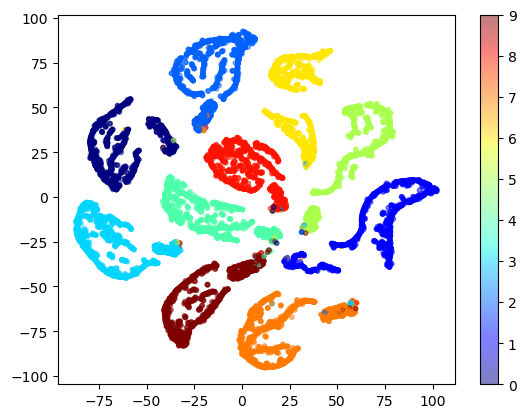

In [42]:
plt.scatter(tsne_features_output[:, 0], tsne_features_output[:, 1], c=labels, cmap='jet', alpha=0.5, s=10)
plt.colorbar()
plt.show()


In [43]:
def extract_conv3_features(model, loader):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            _, _, _, _, conv3_out, _, _ = model(x)
            features.append(conv3_out.cpu().numpy()) 
            labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

features, labels = extract_conv3_features(model, test_loader)

tsne = TSNE(n_components=2)
tsne_features_c5 = tsne.fit_transform(features.reshape(features.shape[0], -1))  # Flatten the features

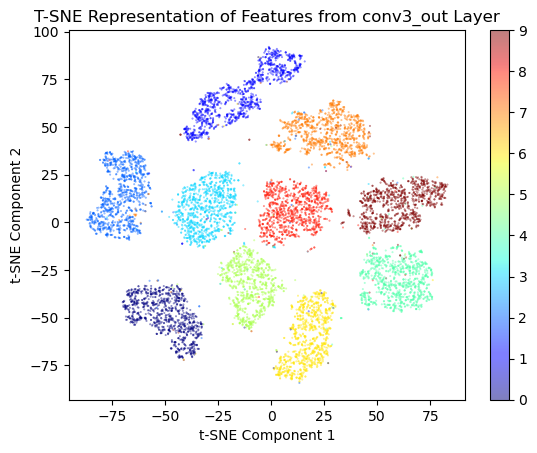

In [44]:
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='jet', alpha=0.5, s=.2)
plt.colorbar()
plt.title('T-SNE Representation of Features from conv3_out Layer')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()